In [1]:
import os
import numpy as np
from PIL import Image
import joblib
import torch
import seaborn as sns
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from FaceNetModel import FaceNetModel
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

c:\Users\ADMIN\anaconda3\envs\AI_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Khai báo các biến và đường dẫn
model_path = 'facenet_model.pth'  # Đường dẫn đến tệp .pth của mô hình
data_dir = './Data/test'  # Đường dẫn đến thư mục dữ liệu

# Chuẩn bị dữ liệu
data_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])


model_facenet = FaceNetModel()
# Load mô hình đã được huấn luyện từ tệp .pth
def load_model(model_path):
    load_weights = torch.load(model_path)
    model_facenet.load_state_dict(load_weights)

load_model(model_path)
model_facenet.to(device).eval()
# model = torch.load(model_path)
# model_facenet = InceptionResnetV1(pretrained='vggface2').to(device).eval()
# Trích xuất biểu diễn nhúng cho dữ liệu huấn luyện
def extract_embeddings(model, phase = 'train'):
    train_embeddings = []
    train_labels = []
    root_path = f'./Data/{phase}'
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = Image.open(file_path)
            img = data_transform(img).unsqueeze_(0)
            embeddings = model(img.to(device))
            embeddings = embeddings.cpu().detach().numpy()[0]
            train_embeddings.append(embeddings)
            train_labels.append(folder)
    return train_embeddings, train_labels

train_embeddings, train_labels = extract_embeddings(model_facenet, 'train')
test_embeddings, test_labels = extract_embeddings(model_facenet, 'test')

In [3]:
np.array(train_embeddings).shape

(3720, 512)

In [31]:
# Khởi tạo mô hình SVM
classifier = SVC(kernel='linear')
# classifier = DecisionTreeClassifier(criterion='entropy', max_depth=30)
# classifier = GaussianNB()
classifier.fit(train_embeddings, train_labels)
# Sử dụng mô hình SVM để dự đoán nhãn cho dữ liệu thử nghiệm
predicted_labels = classifier.predict(test_embeddings)

# Đánh giá mô hình SVM
accuracy = accuracy_score(test_labels, predicted_labels)
m = confusion_matrix(test_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')
m

Accuracy: 99.85%


array([[264,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 239,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0, 252,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 228,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 312,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 252,   0,   0,   0,   0],
       [  3,   0,   0,   0,   0,   0, 273,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 312,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 240,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 216]], dtype=int64)

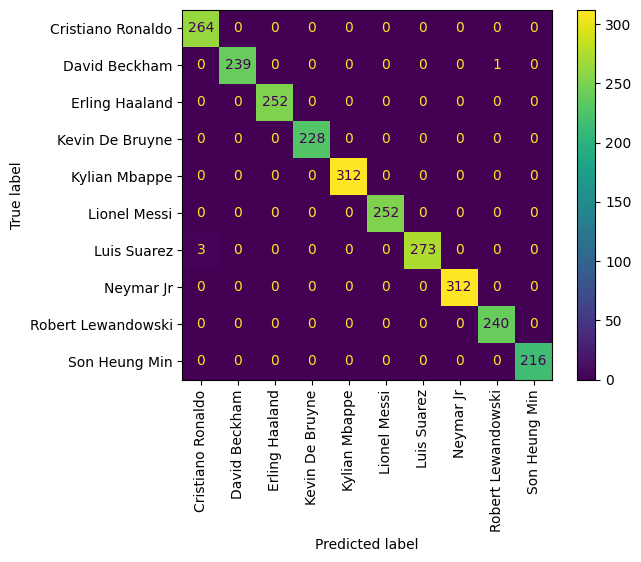

In [32]:
ConfusionMatrixDisplay(m, display_labels=classifier.classes_).plot(xticks_rotation=90);

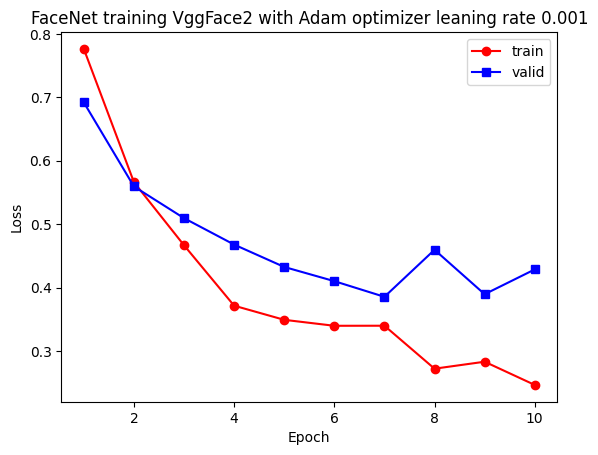

In [6]:
plt.plot(np.arange(1,11), Loss_train, color='red', label = 'train', marker = 'o')
plt.plot(np.arange(1,11), Loss_val, color='blue', label = 'valid', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FaceNet training VggFace2 with Adam optimizer leaning rate 0.001')
plt.legend()

In [6]:
import cv2
import os
from facenet_pytorch import MTCNN
import face_detection
import torch
from matplotlib import pyplot as plt
from PIL import Image
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mtcnn = MTCNN(thresholds=[0.7,0.8,0.8], device=device)
detector_RetinaNetMobileNetV1 = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)
detector_RetinaNetResNet50 = face_detection.build_detector("RetinaNetResNet50", confidence_threshold=.5, nms_iou_threshold=.3)


def detect_face(root_path, target_path, detector):
    scores = []
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            img = cv2.imread(image_path)
            detections = detector.detect(img)
            for detection in detections:  # Assuming you are interested in the first set of face detections
                x, y, z, t = map(int, detection[:4])
                score = detection[4]
                scores.append(score)
    return sum(scores)/len(scores)

if __name__ == '__main__':
    time_start = time.time()
    score_RetinaNetMobileNetV1 = detect_face('./Img', './Img_detected', detector_RetinaNetMobileNetV1)
    time_end = time.time()
    time_RetinaNetMobileNetV1 = time_end - time_start
    time_start = time.time()
    score_RetinaNetResNet50 = detect_face('./Img', './Img_detected', detector_RetinaNetResNet50)
    time_end = time.time()
    time_RetinaNetResNet50 = time_end - time_start

In [9]:
print(f"RetinaNetMobileNetV1: score = {round(score_RetinaNetMobileNetV1,2)}, time = {round(time_RetinaNetMobileNetV1, 2)}")
print(f"RetinaNetResNet50: score = {round(score_RetinaNetResNet50,2)}, time = {round(time_RetinaNetResNet50, 2)}")

RetinaNetMobileNetV1: score = 0.97, time = 8.38
RetinaNetResNet50: score = 0.99, time = 10.66


In [30]:
a = np.random.randint(0, 256, (10, 10))
a

array([[ 32,  66,  82, 191,  99,  37, 143, 199,  45, 216],
       [ 48,  75, 203, 123,  18,  87, 184, 165,  95, 235],
       [ 43, 110, 175, 228,  93,  79,  21, 179,  11, 188],
       [117,   8, 118, 152,  98, 131, 166,   1, 170, 105],
       [ 77,  69,  24,  65, 112,  84, 186,  57, 201, 229],
       [ 49,  21, 165,  42, 184,  31, 164, 240,  49, 230],
       [ 24, 214,   5,  90,  99, 222,  41, 243, 245, 110],
       [ 90,  85, 151, 236,  81,  75, 241,  22, 146, 157],
       [ 87, 186,  62, 208,  61, 122, 151,  60, 193,  28],
       [214, 107, 204, 183,   8, 198,  11, 112, 101, 209]])

In [33]:
np.round(a/255, 2)

array([[0.13, 0.26, 0.32, 0.75, 0.39, 0.15, 0.56, 0.78, 0.18, 0.85],
       [0.19, 0.29, 0.8 , 0.48, 0.07, 0.34, 0.72, 0.65, 0.37, 0.92],
       [0.17, 0.43, 0.69, 0.89, 0.36, 0.31, 0.08, 0.7 , 0.04, 0.74],
       [0.46, 0.03, 0.46, 0.6 , 0.38, 0.51, 0.65, 0.  , 0.67, 0.41],
       [0.3 , 0.27, 0.09, 0.25, 0.44, 0.33, 0.73, 0.22, 0.79, 0.9 ],
       [0.19, 0.08, 0.65, 0.16, 0.72, 0.12, 0.64, 0.94, 0.19, 0.9 ],
       [0.09, 0.84, 0.02, 0.35, 0.39, 0.87, 0.16, 0.95, 0.96, 0.43],
       [0.35, 0.33, 0.59, 0.93, 0.32, 0.29, 0.95, 0.09, 0.57, 0.62],
       [0.34, 0.73, 0.24, 0.82, 0.24, 0.48, 0.59, 0.24, 0.76, 0.11],
       [0.84, 0.42, 0.8 , 0.72, 0.03, 0.78, 0.04, 0.44, 0.4 , 0.82]])

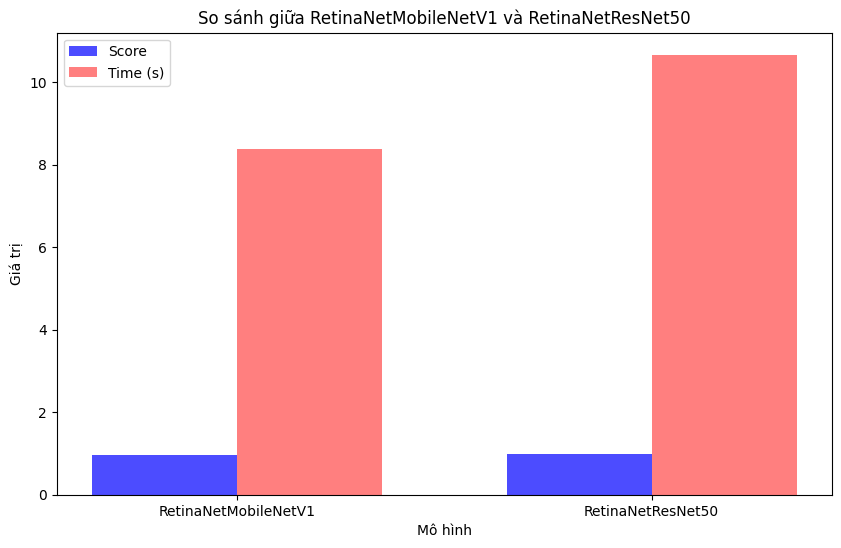

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu điểm số và thời gian cho hai mô hình
scores = [score_RetinaNetMobileNetV1, score_RetinaNetResNet50]
times = [time_RetinaNetMobileNetV1, time_RetinaNetResNet50]
models = ["RetinaNetMobileNetV1", "RetinaNetResNet50"]

# Tạo mảng để xác định vị trí của các cột
x = np.arange(len(models))

# Độ rộng của các cột
width = 0.35

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, scores, width, label='Score', color='b', alpha=0.7)
rects2 = ax.bar(x + width/2, times, width, label='Time (s)', color='r', alpha=0.5)

# Đặt nhãn trục x và các nhãn của các cột
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_xlabel('Mô hình')
ax.set_ylabel('Giá trị')
ax.set_title('So sánh giữa RetinaNetMobileNetV1 và RetinaNetResNet50')
ax.legend()

plt.show()